In [1]:
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

df = pd.read_csv(
    "../crawl/data/clean/df_combine.csv",
    na_values=['-1'], index_col=False)
df

,Date,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,fdi_vn,fdi_us
0,2013-01-01,20760.0,20810.0,20860.0,0.0707,0.016,1.390000,40.6
1,2013-01-02,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
2,2013-01-03,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
3,2013-01-04,20770.0,20820.0,20860.0,0.0707,0.016,1.390000,40.6
4,2013-01-05,20765.0,20815.0,20855.0,0.0707,0.016,1.390000,40.6
...,...,...,...,...,...,...,...,...
4005,2023-12-27,24110.0,24140.0,24480.0,0.0358,0.034,20.476667,66.4
4006,2023-12-28,24030.0,24060.0,24400.0,0.0358,0.034,20.476667,66.4
4007,2023-12-29,24050.0,24080.0,24420.0,0.0358,0.034,20.476667,66.4
4008,2023-12-30,24050.0,24080.0,24420.0,0.0358,0.034,20.476667,66.4


In [3]:
# Data Preprocessing
df_train = df[df['Date'] < '2020-06-01']
df_val_tmp = df[df['Date'] >= '2020-06-01']

# Get the indices of the filtered training data
val_idx = df_val_tmp.index
test_size = int(0.5 * len(val_idx))

# # Split indices into train and validation sets
train_indices = val_idx[:-test_size]
val_indices = val_idx[-test_size:]

# Create train and validation DataFrames
df_val = df_val_tmp.loc[train_indices]
df_test = df_val_tmp.loc[val_indices]

# print(train_indices, val_indices)
df_train.shape, df_val.shape, df_test.shape

((2701, 8), (655, 8), (654, 8))

In [4]:
spots_train = df_train['Sell'].to_numpy().reshape(-1, 1)
spots_val = df_val['Sell'].to_numpy().reshape(-1, 1)
spots_test = df_test['Sell'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_val = scaler.transform(spots_val).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

In [5]:
from re import X
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_val, y_val = to_sequences(SEQUENCE_SIZE, spots_val)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [8]:
model = TransformerModel().to(device)
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        # Collect train loss for this batch
        train_losses.append(loss.item())

    # Calculate average training loss for this epoch
    epoch_train_loss = np.mean(train_losses)
    train_loss_list.append(epoch_train_loss)

    # Validation
    model.eval()
    val_losses = []
    test_losses = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            val_loss = criterion(outputs, y_batch)
            val_losses.append(val_loss.item())
        
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            test_loss = criterion(outputs, y_batch)
            test_losses.append(test_loss.item())
            # predictions.extend(outputs.squeeze().tolist())

    epoch_test_loss = np.mean(test_losses)

    epoch_val_loss = np.mean(val_losses)
    scheduler.step(val_loss)
    # Append val loss to list
    val_loss_list.append(epoch_val_loss)

    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        early_stop_count = 0
        torch.save(model.state_dict(), 'weight/best_uni_transformer.pth')
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

Epoch 1/1000, Train Loss: 0.1633, Validation Loss: 0.0511, Test Loss: 0.4992
Epoch 2/1000, Train Loss: 0.1567, Validation Loss: 0.0315, Test Loss: 0.3247
Epoch 3/1000, Train Loss: 0.0728, Validation Loss: 0.0261, Test Loss: 0.2635
Epoch 4/1000, Train Loss: 0.0445, Validation Loss: 0.0272, Test Loss: 0.2359
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.
Epoch 5/1000, Train Loss: 0.0392, Validation Loss: 0.0253, Test Loss: 0.2001
Epoch 6/1000, Train Loss: 0.0325, Validation Loss: 0.0194, Test Loss: 0.1811
Epoch 7/1000, Train Loss: 0.0239, Validation Loss: 0.0185, Test Loss: 0.1955
Epoch 8/1000, Train Loss: 0.0260, Validation Loss: 0.0245, Test Loss: 0.2023
Epoch 9/1000, Train Loss: 0.0268, Validation Loss: 0.0263, Test Loss: 0.1974
Epoch 00010: reducing learning rate of group 0 to 2.5000e-05.
Epoch 10/1000, Train Loss: 0.0244, Validation Loss: 0.0179, Test Loss: 0.2002
Epoch 11/1000, Train Loss: 0.0214, Validation Loss: 0.0344, Test Loss: 0.1587
Epoch 12/1000, Train Loss: 

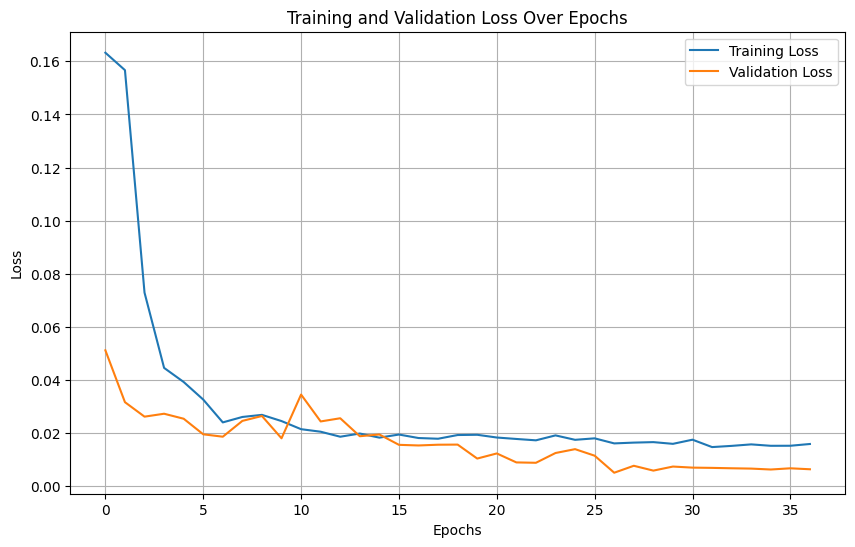

In [9]:
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

We can now evaluate the performance of this model.

In [10]:
model = TransformerModel().to(device)
model.load_state_dict(torch.load('weight/uni_transformer.pth'))
model.eval()

TransformerModel(
  (encoder): Linear(in_features=1, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
encoder.weight 	 torch.Size([128, 1])
encoder.bias 	 torch.Size([128])
pos_encoder.pe 	 torch.Size([5000, 1, 128])
transformer_encoder.layers.0.self_attn.in_proj_weight 	 torch.Size([384, 128])
transformer_encoder.layers.0.self_attn.in_proj_bias 	 torch.Size([384])
transformer_encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([128, 128])
transformer_encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([128])
transformer_encoder.layers.0.linear1.weight 	 torch.Size([2048, 128])
transformer_encoder.layers.0.linear1.bias 	 torch.Size([2048])
transformer_encoder.layers.0.linear2.weight 	 torch.Size([128, 2048])
transformer_encoder.layers.0.linear2.bias 	 torch.Size([128])
transformer_encoder.layers.0.norm1.weight 	 torch.Size([128])
transformer_encoder.layers.0.norm1.bias 	 torch.Size([128])
transformer_encoder.layers.0.norm2.weight 	 torch.Size([128])
transformer_encoder.layers.0.norm2.bias 	 torch.Size([128])
transformer_encoder.layers.1.self_attn.in_proj_weigh

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

# Convert predictions and ground truth to numpy arrays
predictions = np.array(predictions)
y_test_numpy = y_test.numpy()

# # Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test_numpy, predictions))
# print(f"Score (RMSE): {rmse:.4f}")

# Calculate MSE
mse = mean_squared_error(y_test_numpy, predictions)
print(f"Score (MSE): {mse:.4f}")

# Calculate MAE
mae = mean_absolute_error(y_test_numpy, predictions)
print(f"Score (MAE): {mae:.4f}")

# # Calculate R-Squared
# r2 = r2_score(y_test_numpy, predictions)
# print(f"Score (R-Squared): {r2:.4f}")

Score (MSE): 0.1210
Score (MAE): 0.2184


In [13]:
# Inverse transform the predictions and ground truth to visualize
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
y_test_inverse = scaler.inverse_transform(y_test_numpy.reshape(-1, 1)).reshape(-1)

len(y_test_inverse), len(predictions_inverse)

(644, 644)

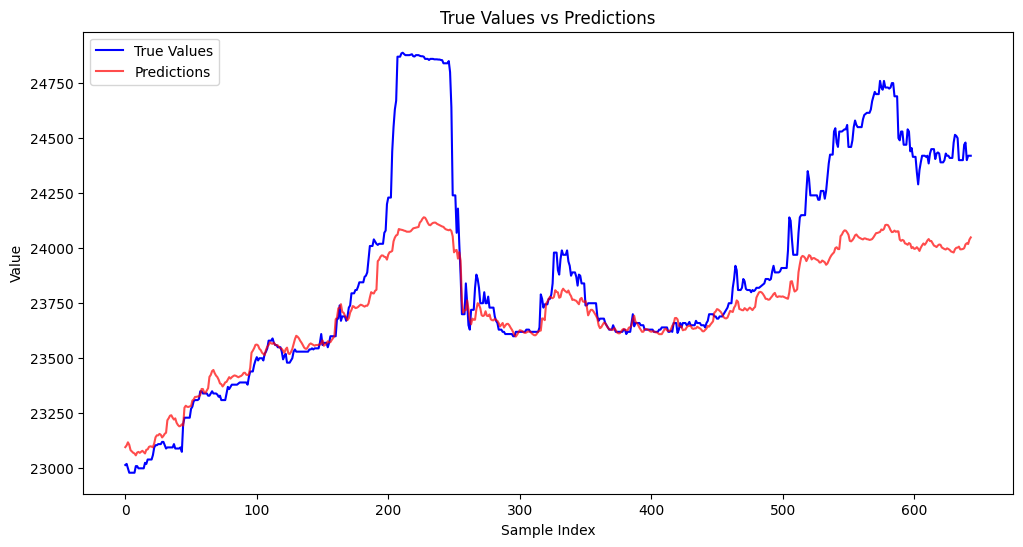

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Values', color='blue')
plt.plot(predictions_inverse, label='Predictions', color='red', alpha=0.7)
plt.title('True Values vs Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()